# Kidney Disease Detection

#### Summary
* It is a classification problem
* Features include numerical values and categorical values
* Need to impute missing numerical values
* Need to impute missing categorical values
* Categorical features need to convert to numerical (get_dummies or DictVectorizer)
* DictVectorizer is introduced
* Pipeline build

#### dataset source
* The chronic kidney disease dataset contains both categorical and numeric features, but contains lots of missing values. The goal here is to predict who has chronic kidney disease given various blood indicators as features.</p>
* The dataset can be download from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease)

#### Package
* There are 3 self defined package: 
    * missing_values_table: check the percetage of missing values and turn it into a table
    * Categorical_Imputer: imputing categorical missing values using the most frequent
    * roc_auc: plot roc curve

## Library

In [1]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# Ipython tool for figsize
from IPython.core.pylabtools import figsize

# train test split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# XGB
import xgboost as xgb

# cross_val_score
from sklearn.model_selection import cross_val_score

# DataframeMapper, CategoricalImputer
from sklearn_pandas import *
from sklearn_pandas import DataFrameMapper

# Imputer
from sklearn.preprocessing import *

# FeatureUnion
from sklearn.pipeline import FeatureUnion

# Function Transformer
from sklearn.preprocessing import FunctionTransformer

# ROC AUC
from sklearn.metrics import roc_auc_score, roc_curve

# EDA
import sweetviz as sv

In [2]:
class Categorical_Imputer:
    """
    Imputing categorical data using the most frequent value
    """
    
    # instance attribute
    def __init__(self, strategy):
        self.strategy = strategy
        
    # instance method
    def fit_transform(self, df:'dataframe')->'dataframe':
        """
        Fill in missing categorical values using most frequent value
        """
        
        # instantiate CategoricalImputer
        imputer = CategoricalImputer()
        
        # convert array to dataframe
        df_filled = df.apply(lambda x: imputer.fit_transform(x), axis=0)
        
        # return filled dataframe
        return df_filled

# Function to calculate missing values by column
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # Print some summary information
    print("Your slelected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

class roc_auc:
    """
    Calculate AUC score, Plot ROC curve
    """
    
    # instance attribute
    def __init__(self, y_test, y_pred_prob, model='model'):
        self.y_test = y_test
        self.y_pred_prob = y_pred_prob
        self.model = model
        
    # instance method
    def auc(self):
        """
        calculate auc score
        """
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        return auc_score
        
    # instance method
    def plot_roc(self):
        """
        plot roc curve
        """
        # AUC score
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        # fpr, tpr, threshold
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_prob)
        
        # ROC curve plot
        _ = plt.plot([0, 1], [0, 1], 'k--')
        _ = plt.plot(fpr, tpr, label= self.model + ' Classifier (AUC = {: .2f})'.format(auc_score))
        _ = plt.xlabel('False Positive Rate')
        _ = plt.ylabel('True Positive Rate')
        _ = plt.legend(loc='lower right')
        _ = plt.title(self.model + ' Classifier ROC Curve')
        _ = plt.show()

# $\rm I.$ Data Preparation
In this section, we load the data, inspect missing values, convert data type, convert target to numerical

## Load Data

In [3]:
# set display columns
pd.set_option('display.max_columns', 30)

In [4]:
# load data
df = pd.read_csv('datasets/chronic_kidney_disease.csv', header=None, 
                 names=['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 
                           'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'])

# head of df
df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,36,1.2,?,?,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,18,0.8,?,?,11.3,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,?,?,9.6,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,?,?,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,?,?,notpresent,notpresent,74,25,1.1,142,3.2,12.2,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68,70,1.010,0,0,?,normal,notpresent,notpresent,100,54,24.0,104,4.0,12.4,36,?,?,no,no,no,good,no,no,ckd
7,24,?,1.015,2,4,normal,abnormal,notpresent,notpresent,410,31,1.1,?,?,12.4,44,6900,5,no,yes,no,good,yes,no,ckd
8,52,100,1.015,3,0,normal,abnormal,present,notpresent,138,60,1.9,?,?,10.8,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


Columns explain:
* age		-	age	
* bp		-	blood pressure
* sg		-	specific gravity
* al		-   albumin
* su		-	sugar
* rbc		-	red blood cells
* pc		-	pus cell
* pcc		-	pus cell clumps
* ba		-	bacteria
* bgr		-	blood glucose random
* bu		-	blood urea
* sc		-	serum creatinine
* sod		-	sodium
* pot		-	potassium
* hemo	    -	hemoglobin
* pcv		-	packed cell volume
* wc		-	white blood cell count
* rc		-	red blood cell count
* htn		-	hypertension
* dm		-	diabetes mellitus
* cad		-	coronary artery disease
* appet	    -	appetite
* pe		-	pedal edema
* ane		-	anemia
* class	    -	class	

## Exporatory Data Analysis

In [5]:
sweet_report = sv.analyze(df)
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [6]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     400 non-null    object
 1   bp      400 non-null    object
 2   sg      400 non-null    object
 3   al      400 non-null    object
 4   su      400 non-null    object
 5   rbc     400 non-null    object
 6   pc      400 non-null    object
 7   pcc     400 non-null    object
 8   ba      400 non-null    object
 9   bgr     400 non-null    object
 10  bu      400 non-null    object
 11  sc      400 non-null    object
 12  sod     400 non-null    object
 13  pot     400 non-null    object
 14  hemo    400 non-null    object
 15  pcv     400 non-null    object
 16  wc      400 non-null    object
 17  rc      400 non-null    object
 18  htn     400 non-null    object
 19  dm      400 non-null    object
 20  cad     400 non-null    object
 21  appet   400 non-null    object
 22  pe      400 non-null    ob

* All columns have dtype object, no matter categorial columns or numerical columns.
* We can see there are some missing values in ?, but pandas does not regard it as missing values.

#### Replace ? with Null

In [7]:
# repace ? values
df.replace('?', np.nan, inplace=True)

df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,36,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,18,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,NaN,NaN,notpresent,notpresent,74,25,1.1,142,3.2,12.2,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68,70,1.010,0,0,NaN,normal,notpresent,notpresent,100,54,24.0,104,4.0,12.4,36,NaN,NaN,no,no,no,good,no,no,ckd
7,24,NaN,1.015,2,4,normal,abnormal,notpresent,notpresent,410,31,1.1,NaN,NaN,12.4,44,6900,5,no,yes,no,good,yes,no,ckd
8,52,100,1.015,3,0,normal,abnormal,present,notpresent,138,60,1.9,NaN,NaN,10.8,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


In [8]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     391 non-null    object
 1   bp      388 non-null    object
 2   sg      353 non-null    object
 3   al      354 non-null    object
 4   su      351 non-null    object
 5   rbc     248 non-null    object
 6   pc      335 non-null    object
 7   pcc     396 non-null    object
 8   ba      396 non-null    object
 9   bgr     356 non-null    object
 10  bu      381 non-null    object
 11  sc      383 non-null    object
 12  sod     313 non-null    object
 13  pot     312 non-null    object
 14  hemo    348 non-null    object
 15  pcv     329 non-null    object
 16  wc      294 non-null    object
 17  rc      269 non-null    object
 18  htn     398 non-null    object
 19  dm      398 non-null    object
 20  cad     398 non-null    object
 21  appet   399 non-null    object
 22  pe      399 non-null    ob

#### Check missing value percentage

In [9]:
# missing value table
missing_values_table(df)

Your slelected dataframe has 25 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
rbc,152,38.00
rc,131,32.75
wc,106,26.50
pot,88,22.00
sod,87,21.75
pcv,71,17.75
pc,65,16.25
hemo,52,13.00
su,49,12.25
sg,47,11.75


#### Convert to Numeric

In [10]:
# numerical columns
num_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

In [11]:
# categorical columns
cate_cols = df.columns.drop('class').drop(num_cols)
# display categorical columns
cate_cols

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [12]:
# convert numerical data 
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [13]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wc      294 non-null    float64
 17  rc      269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [14]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


#### Categorical Feature Unique Values

In [15]:
# categorical columns
cate_cols = df.columns.drop('class').drop(num_cols)
# display categorical columns
cate_cols

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [16]:
# check the number of unique values
df[cate_cols].apply(lambda x: x.nunique(), axis=0)

rbc      2
pc       2
pcc      2
ba       2
htn      2
dm       3
cad      2
appet    2
pe       2
ane      2
dtype: int64

In [17]:
# Problem found on df['dm'], string has extra space
df['dm'].unique()

array(['yes', 'no', ' yes', nan], dtype=object)

In [18]:
df['dm'].dtype

dtype('O')

In [19]:
# delete the space
df['dm'] = df['dm'].str.strip()

**If not delete this extra space, an error will be caused in pipeline due to X_train and X_test dimension not match!**

#### Convert target into 0 and 1

In [20]:
# convert categorical target to numerical
df['class'] = df['class'].apply(lambda x: 1 if x=='ckd' else 0)

# show the head of df['class']
df['class'].head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [21]:
# X and y
X = df.drop(columns=['class'])
y= df['class']

In X, we have missing values for both numerical and categorical data.

# $\rm II.$ Sklearn Imputer and Pandas Get Dummies Approach
In this section, we use sklearn Imputer to impute missing numerical and categorical missing values. We use pandas getdummies to turn categorical values into numerical values.

In [22]:
# load X and y
X = df.drop(columns=['class'])
y= df['class']

## Imputing Data

In [23]:
# define numerical imputer
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')

In [24]:
# imputing on numerical data
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [25]:
# define categorical imputer
cate_imputer = SimpleImputer(strategy="most_frequent") 

In [26]:
# imputing on categorical data
X[cate_cols] = cate_imputer.fit_transform(X[cate_cols])

In [27]:
# X head
X.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
5,60.0,90.0,1.015,3.0,0.0,normal,normal,notpresent,notpresent,74.0,25.0,1.1,142.0,3.2,12.2,39.0,7800.0,4.4,yes,yes,no,good,yes,no
6,68.0,70.0,1.010,0.0,0.0,normal,normal,notpresent,notpresent,100.0,54.0,24.0,104.0,4.0,12.4,36.0,8000.0,4.8,no,no,no,good,no,no
7,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,31.0,1.1,138.0,4.4,12.4,44.0,6900.0,5.0,no,yes,no,good,yes,no
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,60.0,1.9,138.0,4.4,10.8,33.0,9600.0,4.0,yes,yes,no,good,no,yes
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes


In [28]:
# missing value table
missing_values_table(X)

Your slelected dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Get dummies
Turn categorical feature into numerical values

In [29]:
# Get dummies
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

# X head
X.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1,1,0,0,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,1,1,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,1,1,0,0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,0,1,0,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,1,1,0,0,0,0,0,0,0,0


In [30]:
# X shape
X.shape

(400, 24)

## RandomForestClassifier

In [31]:
# Instantiate RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_cl = RandomForestClassifier()

In [32]:
# cross validation score
cv_scores = cross_val_score(rf_cl, X, y, scoring='roc_auc', cv=3)

In [33]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.9995993497800727


## Fit Model

In [34]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [35]:
# fit the model
rf_cl.fit(X_train, y_train)

RandomForestClassifier()

## ROC AUC Curve

In [36]:
# predict on the test set
y_pred_prob = rf_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [37]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='RF')

In [38]:
# AUC score
ROC.auc()

0.9986666666666666

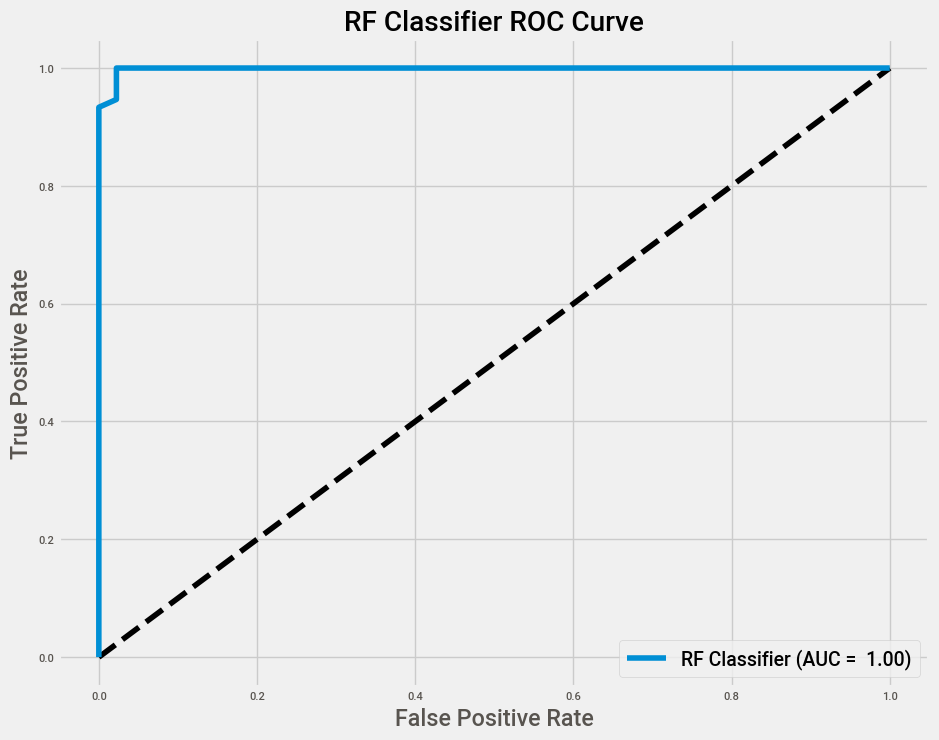

In [39]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

# XGBClassifier

In [40]:
# Instantiate XGBClassifier
xgb_cl = xgb.XGBClassifier()

In [41]:
# cross validation score
cv_scores = cross_val_score(xgb_cl, X, y, scoring='roc_auc', cv=3)

In [42]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.998156435264869


## Fit Model

In [43]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [44]:
# fit the model
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## ROC AUC Curve

In [45]:
# predict on the test set
y_pred_prob = xgb_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [46]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='XGB')

In [47]:
# AUC score
ROC.auc()

0.9961481481481482

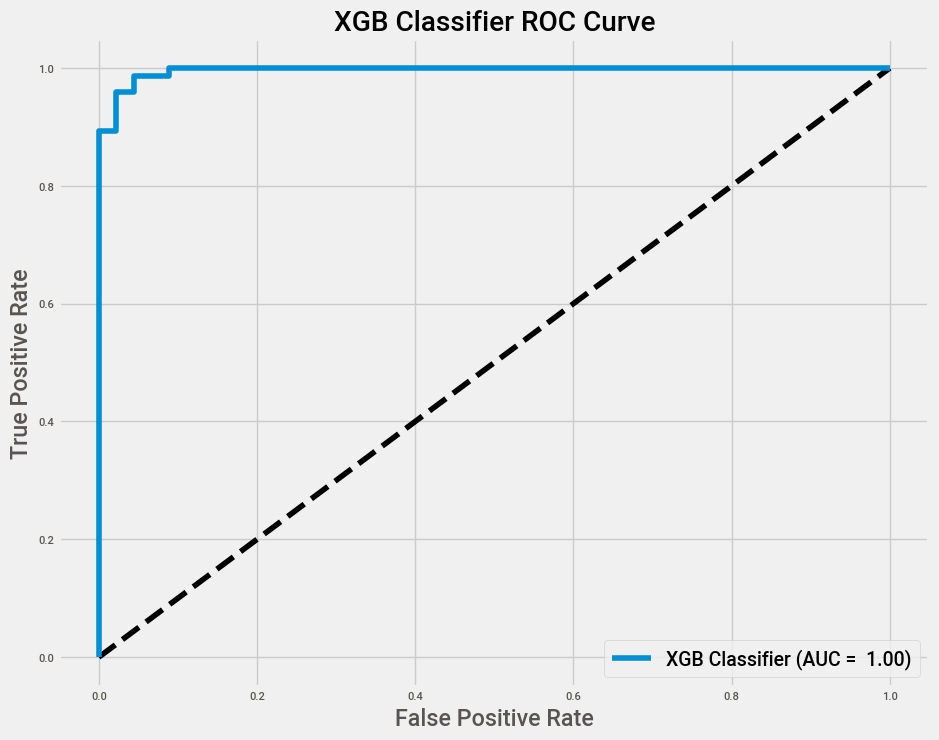

In [48]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

## Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

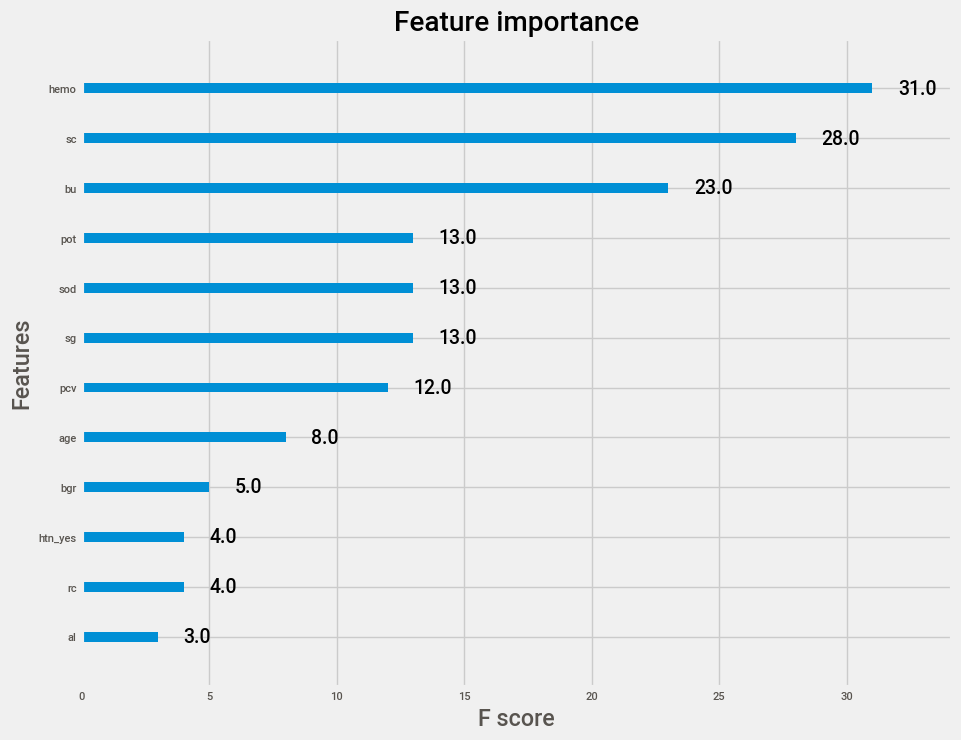

In [49]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot feature importance
xgb.plot_importance(xgb_cl)

# CatBoostClassifier

In [50]:
# Instantiate CatBoostClassifier
from catboost import CatBoostClassifier
cbc_cl = CatBoostClassifier()

In [51]:
# cross validation score
cv_scores = cross_val_score(cbc_cl, X, y, scoring='roc_auc', cv=3)

Learning rate set to 0.005853
0:	learn: 0.6833620	total: 159ms	remaining: 2m 39s
1:	learn: 0.6744971	total: 162ms	remaining: 1m 20s
2:	learn: 0.6649067	total: 164ms	remaining: 54.4s
3:	learn: 0.6571738	total: 166ms	remaining: 41.3s
4:	learn: 0.6487533	total: 168ms	remaining: 33.5s
5:	learn: 0.6403155	total: 170ms	remaining: 28.2s
6:	learn: 0.6312621	total: 173ms	remaining: 24.5s
7:	learn: 0.6230431	total: 175ms	remaining: 21.7s
8:	learn: 0.6159905	total: 177ms	remaining: 19.5s
9:	learn: 0.6072801	total: 180ms	remaining: 17.8s
10:	learn: 0.5992802	total: 183ms	remaining: 16.4s
11:	learn: 0.5918273	total: 185ms	remaining: 15.3s
12:	learn: 0.5841777	total: 188ms	remaining: 14.3s
13:	learn: 0.5755661	total: 189ms	remaining: 13.3s
14:	learn: 0.5672387	total: 192ms	remaining: 12.6s
15:	learn: 0.5600184	total: 195ms	remaining: 12s
16:	learn: 0.5520261	total: 198ms	remaining: 11.4s
17:	learn: 0.5445106	total: 201ms	remaining: 11s
18:	learn: 0.5381520	total: 203ms	remaining: 10.5s
19:	learn: 0.

165:	learn: 0.1168997	total: 526ms	remaining: 2.64s
166:	learn: 0.1158962	total: 528ms	remaining: 2.63s
167:	learn: 0.1148461	total: 530ms	remaining: 2.63s
168:	learn: 0.1139665	total: 533ms	remaining: 2.62s
169:	learn: 0.1132575	total: 535ms	remaining: 2.61s
170:	learn: 0.1124795	total: 537ms	remaining: 2.6s
171:	learn: 0.1117435	total: 539ms	remaining: 2.6s
172:	learn: 0.1108762	total: 541ms	remaining: 2.59s
173:	learn: 0.1100435	total: 544ms	remaining: 2.58s
174:	learn: 0.1093318	total: 555ms	remaining: 2.62s
175:	learn: 0.1084910	total: 557ms	remaining: 2.61s
176:	learn: 0.1076381	total: 561ms	remaining: 2.61s
177:	learn: 0.1068133	total: 564ms	remaining: 2.6s
178:	learn: 0.1061165	total: 566ms	remaining: 2.6s
179:	learn: 0.1053835	total: 569ms	remaining: 2.59s
180:	learn: 0.1046925	total: 571ms	remaining: 2.58s
181:	learn: 0.1038756	total: 573ms	remaining: 2.57s
182:	learn: 0.1032979	total: 575ms	remaining: 2.57s
183:	learn: 0.1026618	total: 577ms	remaining: 2.56s
184:	learn: 0.10

400:	learn: 0.0330653	total: 1.04s	remaining: 1.55s
401:	learn: 0.0329833	total: 1.04s	remaining: 1.55s
402:	learn: 0.0328374	total: 1.04s	remaining: 1.55s
403:	learn: 0.0327362	total: 1.05s	remaining: 1.54s
404:	learn: 0.0326250	total: 1.05s	remaining: 1.54s
405:	learn: 0.0324968	total: 1.05s	remaining: 1.54s
406:	learn: 0.0323606	total: 1.05s	remaining: 1.53s
407:	learn: 0.0322323	total: 1.05s	remaining: 1.53s
408:	learn: 0.0321547	total: 1.06s	remaining: 1.53s
409:	learn: 0.0320099	total: 1.06s	remaining: 1.52s
410:	learn: 0.0319107	total: 1.06s	remaining: 1.52s
411:	learn: 0.0317715	total: 1.06s	remaining: 1.52s
412:	learn: 0.0316238	total: 1.07s	remaining: 1.51s
413:	learn: 0.0315273	total: 1.07s	remaining: 1.51s
414:	learn: 0.0314231	total: 1.07s	remaining: 1.51s
415:	learn: 0.0313319	total: 1.07s	remaining: 1.5s
416:	learn: 0.0311868	total: 1.07s	remaining: 1.5s
417:	learn: 0.0310812	total: 1.08s	remaining: 1.5s
418:	learn: 0.0309719	total: 1.08s	remaining: 1.5s
419:	learn: 0.03

565:	learn: 0.0192626	total: 1.38s	remaining: 1.06s
566:	learn: 0.0192140	total: 1.38s	remaining: 1.05s
567:	learn: 0.0191591	total: 1.38s	remaining: 1.05s
568:	learn: 0.0191139	total: 1.39s	remaining: 1.05s
569:	learn: 0.0190590	total: 1.39s	remaining: 1.05s
570:	learn: 0.0190179	total: 1.39s	remaining: 1.04s
571:	learn: 0.0189553	total: 1.39s	remaining: 1.04s
572:	learn: 0.0189059	total: 1.39s	remaining: 1.04s
573:	learn: 0.0188506	total: 1.4s	remaining: 1.04s
574:	learn: 0.0187855	total: 1.4s	remaining: 1.03s
575:	learn: 0.0187410	total: 1.4s	remaining: 1.03s
576:	learn: 0.0186755	total: 1.4s	remaining: 1.03s
577:	learn: 0.0186372	total: 1.41s	remaining: 1.02s
578:	learn: 0.0185929	total: 1.41s	remaining: 1.02s
579:	learn: 0.0185215	total: 1.41s	remaining: 1.02s
580:	learn: 0.0184656	total: 1.41s	remaining: 1.02s
581:	learn: 0.0184142	total: 1.41s	remaining: 1.01s
582:	learn: 0.0183629	total: 1.42s	remaining: 1.01s
583:	learn: 0.0183085	total: 1.42s	remaining: 1.01s
584:	learn: 0.01

733:	learn: 0.0127972	total: 1.71s	remaining: 621ms
734:	learn: 0.0127738	total: 1.72s	remaining: 619ms
735:	learn: 0.0127430	total: 1.72s	remaining: 616ms
736:	learn: 0.0127260	total: 1.72s	remaining: 614ms
737:	learn: 0.0127018	total: 1.72s	remaining: 612ms
738:	learn: 0.0126745	total: 1.72s	remaining: 609ms
739:	learn: 0.0126511	total: 1.73s	remaining: 607ms
740:	learn: 0.0126219	total: 1.73s	remaining: 604ms
741:	learn: 0.0125999	total: 1.73s	remaining: 602ms
742:	learn: 0.0125812	total: 1.73s	remaining: 600ms
743:	learn: 0.0125369	total: 1.74s	remaining: 597ms
744:	learn: 0.0125210	total: 1.74s	remaining: 595ms
745:	learn: 0.0124935	total: 1.74s	remaining: 592ms
746:	learn: 0.0124617	total: 1.74s	remaining: 590ms
747:	learn: 0.0124310	total: 1.74s	remaining: 588ms
748:	learn: 0.0124015	total: 1.75s	remaining: 585ms
749:	learn: 0.0123645	total: 1.75s	remaining: 583ms
750:	learn: 0.0123448	total: 1.75s	remaining: 580ms
751:	learn: 0.0123175	total: 1.75s	remaining: 578ms
752:	learn: 

900:	learn: 0.0092748	total: 2.06s	remaining: 227ms
901:	learn: 0.0092533	total: 2.07s	remaining: 225ms
902:	learn: 0.0092407	total: 2.07s	remaining: 222ms
903:	learn: 0.0092273	total: 2.07s	remaining: 220ms
904:	learn: 0.0092110	total: 2.07s	remaining: 218ms
905:	learn: 0.0091901	total: 2.08s	remaining: 215ms
906:	learn: 0.0091736	total: 2.08s	remaining: 213ms
907:	learn: 0.0091590	total: 2.08s	remaining: 211ms
908:	learn: 0.0091431	total: 2.08s	remaining: 208ms
909:	learn: 0.0091263	total: 2.08s	remaining: 206ms
910:	learn: 0.0091085	total: 2.08s	remaining: 204ms
911:	learn: 0.0090898	total: 2.09s	remaining: 201ms
912:	learn: 0.0090745	total: 2.09s	remaining: 199ms
913:	learn: 0.0090580	total: 2.09s	remaining: 197ms
914:	learn: 0.0090436	total: 2.09s	remaining: 195ms
915:	learn: 0.0090215	total: 2.1s	remaining: 192ms
916:	learn: 0.0090078	total: 2.1s	remaining: 190ms
917:	learn: 0.0089938	total: 2.1s	remaining: 188ms
918:	learn: 0.0089731	total: 2.1s	remaining: 185ms
919:	learn: 0.00

119:	learn: 0.1610798	total: 256ms	remaining: 1.88s
120:	learn: 0.1597077	total: 258ms	remaining: 1.88s
121:	learn: 0.1583165	total: 261ms	remaining: 1.88s
122:	learn: 0.1567971	total: 263ms	remaining: 1.87s
123:	learn: 0.1549369	total: 265ms	remaining: 1.87s
124:	learn: 0.1534650	total: 267ms	remaining: 1.87s
125:	learn: 0.1520282	total: 269ms	remaining: 1.86s
126:	learn: 0.1505336	total: 271ms	remaining: 1.86s
127:	learn: 0.1493727	total: 273ms	remaining: 1.86s
128:	learn: 0.1480969	total: 276ms	remaining: 1.86s
129:	learn: 0.1467632	total: 278ms	remaining: 1.86s
130:	learn: 0.1453105	total: 280ms	remaining: 1.86s
131:	learn: 0.1435845	total: 282ms	remaining: 1.85s
132:	learn: 0.1425045	total: 284ms	remaining: 1.85s
133:	learn: 0.1410347	total: 286ms	remaining: 1.85s
134:	learn: 0.1397671	total: 288ms	remaining: 1.85s
135:	learn: 0.1387172	total: 290ms	remaining: 1.84s
136:	learn: 0.1372400	total: 292ms	remaining: 1.84s
137:	learn: 0.1358840	total: 294ms	remaining: 1.84s
138:	learn: 

281:	learn: 0.0496120	total: 596ms	remaining: 1.52s
282:	learn: 0.0492950	total: 599ms	remaining: 1.52s
283:	learn: 0.0490314	total: 601ms	remaining: 1.51s
284:	learn: 0.0488524	total: 603ms	remaining: 1.51s
285:	learn: 0.0486254	total: 605ms	remaining: 1.51s
286:	learn: 0.0483313	total: 608ms	remaining: 1.51s
287:	learn: 0.0480506	total: 610ms	remaining: 1.51s
288:	learn: 0.0477732	total: 612ms	remaining: 1.51s
289:	learn: 0.0475671	total: 615ms	remaining: 1.5s
290:	learn: 0.0473492	total: 617ms	remaining: 1.5s
291:	learn: 0.0470696	total: 619ms	remaining: 1.5s
292:	learn: 0.0467655	total: 622ms	remaining: 1.5s
293:	learn: 0.0465045	total: 624ms	remaining: 1.5s
294:	learn: 0.0462011	total: 626ms	remaining: 1.5s
295:	learn: 0.0459556	total: 628ms	remaining: 1.49s
296:	learn: 0.0457046	total: 630ms	remaining: 1.49s
297:	learn: 0.0454655	total: 632ms	remaining: 1.49s
298:	learn: 0.0452008	total: 634ms	remaining: 1.49s
299:	learn: 0.0449563	total: 636ms	remaining: 1.49s
300:	learn: 0.0446

442:	learn: 0.0248879	total: 940ms	remaining: 1.18s
443:	learn: 0.0248181	total: 942ms	remaining: 1.18s
444:	learn: 0.0247555	total: 945ms	remaining: 1.18s
445:	learn: 0.0246645	total: 947ms	remaining: 1.18s
446:	learn: 0.0245880	total: 949ms	remaining: 1.17s
447:	learn: 0.0245191	total: 952ms	remaining: 1.17s
448:	learn: 0.0244423	total: 954ms	remaining: 1.17s
449:	learn: 0.0243433	total: 956ms	remaining: 1.17s
450:	learn: 0.0242548	total: 959ms	remaining: 1.17s
451:	learn: 0.0241644	total: 961ms	remaining: 1.17s
452:	learn: 0.0240807	total: 963ms	remaining: 1.16s
453:	learn: 0.0240057	total: 965ms	remaining: 1.16s
454:	learn: 0.0239598	total: 967ms	remaining: 1.16s
455:	learn: 0.0238780	total: 969ms	remaining: 1.16s
456:	learn: 0.0237923	total: 972ms	remaining: 1.15s
457:	learn: 0.0237210	total: 974ms	remaining: 1.15s
458:	learn: 0.0236564	total: 976ms	remaining: 1.15s
459:	learn: 0.0235866	total: 978ms	remaining: 1.15s
460:	learn: 0.0235147	total: 980ms	remaining: 1.15s
461:	learn: 

681:	learn: 0.0128815	total: 1.45s	remaining: 676ms
682:	learn: 0.0128538	total: 1.45s	remaining: 674ms
683:	learn: 0.0128264	total: 1.45s	remaining: 672ms
684:	learn: 0.0128079	total: 1.46s	remaining: 670ms
685:	learn: 0.0127797	total: 1.46s	remaining: 668ms
686:	learn: 0.0127384	total: 1.46s	remaining: 666ms
687:	learn: 0.0127138	total: 1.46s	remaining: 664ms
688:	learn: 0.0126820	total: 1.47s	remaining: 662ms
689:	learn: 0.0126491	total: 1.47s	remaining: 660ms
690:	learn: 0.0126242	total: 1.47s	remaining: 658ms
691:	learn: 0.0125870	total: 1.47s	remaining: 656ms
692:	learn: 0.0125622	total: 1.48s	remaining: 654ms
693:	learn: 0.0125340	total: 1.48s	remaining: 652ms
694:	learn: 0.0125003	total: 1.48s	remaining: 650ms
695:	learn: 0.0124677	total: 1.48s	remaining: 648ms
696:	learn: 0.0124415	total: 1.49s	remaining: 646ms
697:	learn: 0.0124134	total: 1.49s	remaining: 644ms
698:	learn: 0.0123862	total: 1.49s	remaining: 642ms
699:	learn: 0.0123610	total: 1.49s	remaining: 640ms
700:	learn: 

903:	learn: 0.0083159	total: 1.96s	remaining: 208ms
904:	learn: 0.0082976	total: 1.97s	remaining: 206ms
905:	learn: 0.0082845	total: 1.97s	remaining: 204ms
906:	learn: 0.0082720	total: 1.97s	remaining: 202ms
907:	learn: 0.0082580	total: 1.97s	remaining: 200ms
908:	learn: 0.0082455	total: 1.97s	remaining: 198ms
909:	learn: 0.0082309	total: 1.98s	remaining: 196ms
910:	learn: 0.0082117	total: 1.98s	remaining: 193ms
911:	learn: 0.0081972	total: 1.98s	remaining: 191ms
912:	learn: 0.0081867	total: 1.98s	remaining: 189ms
913:	learn: 0.0081760	total: 1.99s	remaining: 187ms
914:	learn: 0.0081618	total: 1.99s	remaining: 185ms
915:	learn: 0.0081487	total: 1.99s	remaining: 183ms
916:	learn: 0.0081377	total: 1.99s	remaining: 180ms
917:	learn: 0.0081246	total: 2s	remaining: 178ms
918:	learn: 0.0081169	total: 2s	remaining: 176ms
919:	learn: 0.0081030	total: 2s	remaining: 174ms
920:	learn: 0.0080886	total: 2s	remaining: 172ms
921:	learn: 0.0080731	total: 2s	remaining: 170ms
922:	learn: 0.0080625	total

103:	learn: 0.1982905	total: 232ms	remaining: 2s
104:	learn: 0.1963970	total: 234ms	remaining: 2s
105:	learn: 0.1945896	total: 236ms	remaining: 1.99s
106:	learn: 0.1923030	total: 239ms	remaining: 1.99s
107:	learn: 0.1898862	total: 241ms	remaining: 1.99s
108:	learn: 0.1876020	total: 243ms	remaining: 1.99s
109:	learn: 0.1852064	total: 245ms	remaining: 1.99s
110:	learn: 0.1838107	total: 247ms	remaining: 1.98s
111:	learn: 0.1820949	total: 249ms	remaining: 1.98s
112:	learn: 0.1802649	total: 252ms	remaining: 1.98s
113:	learn: 0.1784906	total: 254ms	remaining: 1.97s
114:	learn: 0.1764544	total: 256ms	remaining: 1.97s
115:	learn: 0.1748755	total: 258ms	remaining: 1.97s
116:	learn: 0.1731695	total: 261ms	remaining: 1.97s
117:	learn: 0.1717555	total: 263ms	remaining: 1.96s
118:	learn: 0.1704231	total: 265ms	remaining: 1.96s
119:	learn: 0.1687538	total: 267ms	remaining: 1.96s
120:	learn: 0.1667221	total: 269ms	remaining: 1.95s
121:	learn: 0.1647839	total: 271ms	remaining: 1.95s
122:	learn: 0.1634

334:	learn: 0.0376868	total: 744ms	remaining: 1.48s
335:	learn: 0.0374701	total: 747ms	remaining: 1.48s
336:	learn: 0.0372886	total: 749ms	remaining: 1.47s
337:	learn: 0.0371248	total: 751ms	remaining: 1.47s
338:	learn: 0.0369544	total: 752ms	remaining: 1.47s
339:	learn: 0.0367764	total: 754ms	remaining: 1.46s
340:	learn: 0.0365880	total: 756ms	remaining: 1.46s
341:	learn: 0.0364100	total: 758ms	remaining: 1.46s
342:	learn: 0.0362196	total: 761ms	remaining: 1.46s
343:	learn: 0.0359695	total: 762ms	remaining: 1.45s
344:	learn: 0.0358148	total: 765ms	remaining: 1.45s
345:	learn: 0.0357050	total: 767ms	remaining: 1.45s
346:	learn: 0.0355907	total: 769ms	remaining: 1.45s
347:	learn: 0.0354376	total: 771ms	remaining: 1.44s
348:	learn: 0.0353061	total: 773ms	remaining: 1.44s
349:	learn: 0.0350865	total: 775ms	remaining: 1.44s
350:	learn: 0.0349787	total: 777ms	remaining: 1.44s
351:	learn: 0.0348190	total: 779ms	remaining: 1.43s
352:	learn: 0.0346682	total: 781ms	remaining: 1.43s
353:	learn: 

502:	learn: 0.0199955	total: 1.09s	remaining: 1.07s
503:	learn: 0.0199220	total: 1.09s	remaining: 1.07s
504:	learn: 0.0198631	total: 1.09s	remaining: 1.07s
505:	learn: 0.0197979	total: 1.09s	remaining: 1.07s
506:	learn: 0.0197484	total: 1.1s	remaining: 1.07s
507:	learn: 0.0196857	total: 1.1s	remaining: 1.06s
508:	learn: 0.0196378	total: 1.1s	remaining: 1.06s
509:	learn: 0.0195766	total: 1.1s	remaining: 1.06s
510:	learn: 0.0195191	total: 1.1s	remaining: 1.06s
511:	learn: 0.0194700	total: 1.11s	remaining: 1.05s
512:	learn: 0.0194007	total: 1.11s	remaining: 1.05s
513:	learn: 0.0193455	total: 1.11s	remaining: 1.05s
514:	learn: 0.0192551	total: 1.11s	remaining: 1.05s
515:	learn: 0.0191931	total: 1.11s	remaining: 1.05s
516:	learn: 0.0191415	total: 1.12s	remaining: 1.04s
517:	learn: 0.0191015	total: 1.12s	remaining: 1.04s
518:	learn: 0.0190189	total: 1.12s	remaining: 1.04s
519:	learn: 0.0189796	total: 1.12s	remaining: 1.04s
520:	learn: 0.0189223	total: 1.13s	remaining: 1.03s
521:	learn: 0.018

669:	learn: 0.0127646	total: 1.43s	remaining: 705ms
670:	learn: 0.0127339	total: 1.43s	remaining: 703ms
671:	learn: 0.0127065	total: 1.44s	remaining: 701ms
672:	learn: 0.0126750	total: 1.44s	remaining: 699ms
673:	learn: 0.0126491	total: 1.44s	remaining: 697ms
674:	learn: 0.0126202	total: 1.44s	remaining: 694ms
675:	learn: 0.0126019	total: 1.44s	remaining: 692ms
676:	learn: 0.0125760	total: 1.45s	remaining: 690ms
677:	learn: 0.0125551	total: 1.45s	remaining: 688ms
678:	learn: 0.0125298	total: 1.45s	remaining: 686ms
679:	learn: 0.0125079	total: 1.45s	remaining: 683ms
680:	learn: 0.0124855	total: 1.45s	remaining: 681ms
681:	learn: 0.0124529	total: 1.46s	remaining: 679ms
682:	learn: 0.0124244	total: 1.46s	remaining: 677ms
683:	learn: 0.0123989	total: 1.46s	remaining: 675ms
684:	learn: 0.0123770	total: 1.46s	remaining: 672ms
685:	learn: 0.0123410	total: 1.46s	remaining: 670ms
686:	learn: 0.0123050	total: 1.47s	remaining: 668ms
687:	learn: 0.0122805	total: 1.47s	remaining: 666ms
688:	learn: 

839:	learn: 0.0090103	total: 1.78s	remaining: 338ms
840:	learn: 0.0089954	total: 1.78s	remaining: 336ms
841:	learn: 0.0089819	total: 1.78s	remaining: 334ms
842:	learn: 0.0089674	total: 1.78s	remaining: 332ms
843:	learn: 0.0089546	total: 1.78s	remaining: 330ms
844:	learn: 0.0089389	total: 1.79s	remaining: 328ms
845:	learn: 0.0089190	total: 1.79s	remaining: 326ms
846:	learn: 0.0088956	total: 1.79s	remaining: 324ms
847:	learn: 0.0088788	total: 1.79s	remaining: 322ms
848:	learn: 0.0088626	total: 1.8s	remaining: 319ms
849:	learn: 0.0088475	total: 1.8s	remaining: 317ms
850:	learn: 0.0088301	total: 1.8s	remaining: 315ms
851:	learn: 0.0088117	total: 1.8s	remaining: 313ms
852:	learn: 0.0087940	total: 1.8s	remaining: 311ms
853:	learn: 0.0087769	total: 1.81s	remaining: 309ms
854:	learn: 0.0087627	total: 1.81s	remaining: 307ms
855:	learn: 0.0087452	total: 1.81s	remaining: 305ms
856:	learn: 0.0087273	total: 1.81s	remaining: 302ms
857:	learn: 0.0087143	total: 1.81s	remaining: 300ms
858:	learn: 0.008

In [52]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.9996796710652133


## Fit Model

In [53]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [54]:
# fit the model
cbc_cl.fit(X_train, y_train)

Learning rate set to 0.005982
0:	learn: 0.6818621	total: 2.46ms	remaining: 2.46s
1:	learn: 0.6734495	total: 4.68ms	remaining: 2.34s
2:	learn: 0.6635224	total: 6.85ms	remaining: 2.28s
3:	learn: 0.6552197	total: 8.94ms	remaining: 2.23s
4:	learn: 0.6456054	total: 10.9ms	remaining: 2.17s
5:	learn: 0.6375213	total: 12.9ms	remaining: 2.14s
6:	learn: 0.6284100	total: 15ms	remaining: 2.13s
7:	learn: 0.6201377	total: 17.5ms	remaining: 2.17s
8:	learn: 0.6129724	total: 18.6ms	remaining: 2.05s
9:	learn: 0.6038016	total: 21ms	remaining: 2.08s
10:	learn: 0.5953104	total: 23.5ms	remaining: 2.11s
11:	learn: 0.5871101	total: 26ms	remaining: 2.14s
12:	learn: 0.5804819	total: 28.4ms	remaining: 2.16s
13:	learn: 0.5708344	total: 30.7ms	remaining: 2.16s
14:	learn: 0.5628463	total: 33ms	remaining: 2.17s
15:	learn: 0.5565945	total: 35.3ms	remaining: 2.17s
16:	learn: 0.5482055	total: 37.4ms	remaining: 2.16s
17:	learn: 0.5407740	total: 39.4ms	remaining: 2.15s
18:	learn: 0.5332605	total: 41.5ms	remaining: 2.14s


212:	learn: 0.0717347	total: 450ms	remaining: 1.66s
213:	learn: 0.0712485	total: 452ms	remaining: 1.66s
214:	learn: 0.0706997	total: 454ms	remaining: 1.66s
215:	learn: 0.0702253	total: 457ms	remaining: 1.66s
216:	learn: 0.0698241	total: 459ms	remaining: 1.65s
217:	learn: 0.0693692	total: 461ms	remaining: 1.65s
218:	learn: 0.0688986	total: 463ms	remaining: 1.65s
219:	learn: 0.0683970	total: 465ms	remaining: 1.65s
220:	learn: 0.0679476	total: 467ms	remaining: 1.65s
221:	learn: 0.0675552	total: 469ms	remaining: 1.64s
222:	learn: 0.0671919	total: 471ms	remaining: 1.64s
223:	learn: 0.0667698	total: 473ms	remaining: 1.64s
224:	learn: 0.0663357	total: 475ms	remaining: 1.63s
225:	learn: 0.0658560	total: 477ms	remaining: 1.63s
226:	learn: 0.0654839	total: 479ms	remaining: 1.63s
227:	learn: 0.0650641	total: 481ms	remaining: 1.63s
228:	learn: 0.0644888	total: 483ms	remaining: 1.63s
229:	learn: 0.0641698	total: 485ms	remaining: 1.62s
230:	learn: 0.0637329	total: 487ms	remaining: 1.62s
231:	learn: 

375:	learn: 0.0299160	total: 788ms	remaining: 1.31s
376:	learn: 0.0297780	total: 791ms	remaining: 1.31s
377:	learn: 0.0296412	total: 793ms	remaining: 1.3s
378:	learn: 0.0295445	total: 795ms	remaining: 1.3s
379:	learn: 0.0293987	total: 797ms	remaining: 1.3s
380:	learn: 0.0292747	total: 799ms	remaining: 1.3s
381:	learn: 0.0291940	total: 801ms	remaining: 1.29s
382:	learn: 0.0290659	total: 803ms	remaining: 1.29s
383:	learn: 0.0289858	total: 805ms	remaining: 1.29s
384:	learn: 0.0288586	total: 807ms	remaining: 1.29s
385:	learn: 0.0287485	total: 809ms	remaining: 1.29s
386:	learn: 0.0286480	total: 811ms	remaining: 1.28s
387:	learn: 0.0285394	total: 813ms	remaining: 1.28s
388:	learn: 0.0284475	total: 815ms	remaining: 1.28s
389:	learn: 0.0283247	total: 818ms	remaining: 1.28s
390:	learn: 0.0282386	total: 820ms	remaining: 1.28s
391:	learn: 0.0281259	total: 823ms	remaining: 1.27s
392:	learn: 0.0280324	total: 825ms	remaining: 1.27s
393:	learn: 0.0279337	total: 827ms	remaining: 1.27s
394:	learn: 0.02

543:	learn: 0.0170811	total: 1.13s	remaining: 951ms
544:	learn: 0.0170300	total: 1.14s	remaining: 949ms
545:	learn: 0.0169796	total: 1.14s	remaining: 947ms
546:	learn: 0.0169268	total: 1.14s	remaining: 945ms
547:	learn: 0.0168962	total: 1.14s	remaining: 942ms
548:	learn: 0.0168615	total: 1.14s	remaining: 940ms
549:	learn: 0.0168155	total: 1.15s	remaining: 938ms
550:	learn: 0.0167816	total: 1.15s	remaining: 936ms
551:	learn: 0.0167151	total: 1.15s	remaining: 933ms
552:	learn: 0.0166741	total: 1.15s	remaining: 931ms
553:	learn: 0.0166334	total: 1.15s	remaining: 929ms
554:	learn: 0.0165811	total: 1.16s	remaining: 927ms
555:	learn: 0.0165452	total: 1.16s	remaining: 925ms
556:	learn: 0.0164901	total: 1.16s	remaining: 923ms
557:	learn: 0.0164509	total: 1.16s	remaining: 921ms
558:	learn: 0.0163995	total: 1.16s	remaining: 919ms
559:	learn: 0.0163509	total: 1.17s	remaining: 916ms
560:	learn: 0.0163127	total: 1.17s	remaining: 914ms
561:	learn: 0.0162650	total: 1.17s	remaining: 912ms
562:	learn: 

712:	learn: 0.0112203	total: 1.48s	remaining: 595ms
713:	learn: 0.0111917	total: 1.48s	remaining: 593ms
714:	learn: 0.0111711	total: 1.48s	remaining: 591ms
715:	learn: 0.0111378	total: 1.48s	remaining: 588ms
716:	learn: 0.0111130	total: 1.49s	remaining: 586ms
717:	learn: 0.0110903	total: 1.49s	remaining: 584ms
718:	learn: 0.0110651	total: 1.49s	remaining: 582ms
719:	learn: 0.0110339	total: 1.49s	remaining: 580ms
720:	learn: 0.0110102	total: 1.49s	remaining: 578ms
721:	learn: 0.0109850	total: 1.5s	remaining: 576ms
722:	learn: 0.0109542	total: 1.5s	remaining: 574ms
723:	learn: 0.0109324	total: 1.5s	remaining: 572ms
724:	learn: 0.0109085	total: 1.5s	remaining: 569ms
725:	learn: 0.0108834	total: 1.5s	remaining: 567ms
726:	learn: 0.0108670	total: 1.5s	remaining: 565ms
727:	learn: 0.0108418	total: 1.51s	remaining: 563ms
728:	learn: 0.0108175	total: 1.51s	remaining: 561ms
729:	learn: 0.0107967	total: 1.51s	remaining: 559ms
730:	learn: 0.0107747	total: 1.51s	remaining: 557ms
731:	learn: 0.0107

879:	learn: 0.0080661	total: 1.83s	remaining: 249ms
880:	learn: 0.0080518	total: 1.83s	remaining: 247ms
881:	learn: 0.0080377	total: 1.83s	remaining: 245ms
882:	learn: 0.0080243	total: 1.83s	remaining: 243ms
883:	learn: 0.0080106	total: 1.83s	remaining: 241ms
884:	learn: 0.0079963	total: 1.84s	remaining: 239ms
885:	learn: 0.0079881	total: 1.84s	remaining: 237ms
886:	learn: 0.0079774	total: 1.84s	remaining: 235ms
887:	learn: 0.0079607	total: 1.84s	remaining: 233ms
888:	learn: 0.0079456	total: 1.84s	remaining: 230ms
889:	learn: 0.0079301	total: 1.85s	remaining: 228ms
890:	learn: 0.0079186	total: 1.85s	remaining: 226ms
891:	learn: 0.0079051	total: 1.85s	remaining: 224ms
892:	learn: 0.0078905	total: 1.85s	remaining: 222ms
893:	learn: 0.0078755	total: 1.86s	remaining: 220ms
894:	learn: 0.0078584	total: 1.86s	remaining: 218ms
895:	learn: 0.0078413	total: 1.86s	remaining: 216ms
896:	learn: 0.0078311	total: 1.86s	remaining: 214ms
897:	learn: 0.0078189	total: 1.86s	remaining: 212ms
898:	learn: 

## ROC AUC Curve

In [55]:
# predict on the test set
y_pred_prob = cbc_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [56]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='CatBoostClassifier')

In [57]:
# AUC score
ROC.auc()

0.9988148148148148

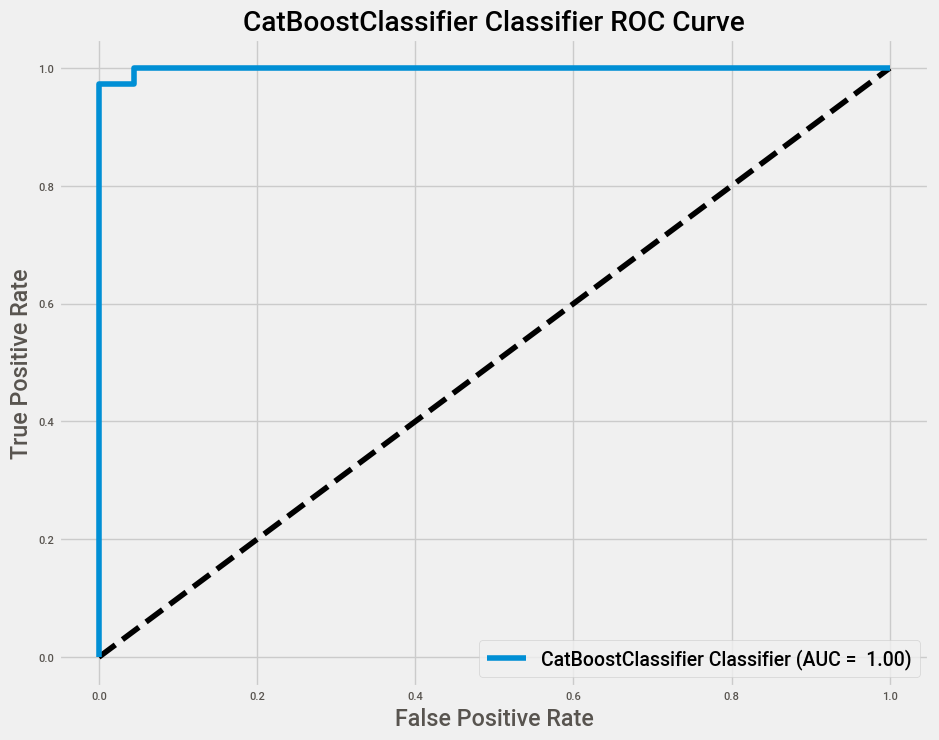

In [58]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

# LGBMClassifier

In [59]:
# Instantiate LGBMClassifier
from lightgbm import LGBMClassifier
lgbm_cl = LGBMClassifier()

In [60]:
# cross validation score
cv_scores = cross_val_score(lgbm_cl, X, y, scoring='roc_auc', cv=3)

In [61]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 1.0


## Fit Model

In [62]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [63]:
# fit the model
lgbm_cl.fit(X_train, y_train)

LGBMClassifier()

## ROC AUC Curve

In [64]:
# predict on the test set
y_pred_prob = lgbm_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [65]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='LGBMClassifier')

In [66]:
# AUC score
ROC.auc()

0.9991111111111112

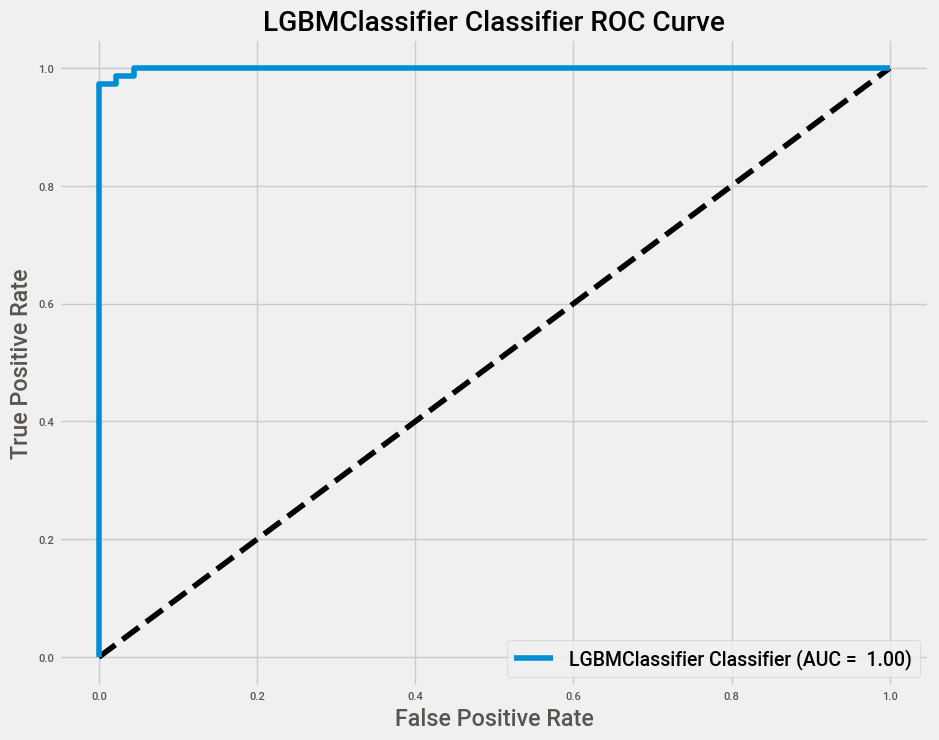

In [67]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()